# **Importing the libraries**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

2025-07-01 22:16:21.674820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751408182.064356      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751408182.169277      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading and Splitting the dataset**

In [2]:
data, ds_info = tfds.load('oxford_iiit_pet', with_info=True)
train_ds = data['train']
test_ds = data['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1751408256.249968      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751408256.250613      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.34SX8R_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.34SX8R_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names

# **Data Augmentation**

In [4]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# **Preprocessing the data**

In [5]:
def preprocess(sample):
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = data_augmentation(image)
    return image, sample['label']

# **Data Preprocessing Pipeline**

In [6]:
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(
    lambda sample: (tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE)) / 255.0, sample['label']),
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# **Building the model using EfficientNetB0**

In [7]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 37)                  │          47,397 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,968 (15.63 MB)

 Trainable params: 47,397 (185.14 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# **Learning Rate Scheduler Callback**

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6)

# **Training th model**

In [11]:
history = model.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[reduce_lr])

Epoch 1/30


I0000 00:00:1751408292.613228     118 service.cc:148] XLA service 0x7c0d400050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751408292.614783     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751408292.614820     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751408294.615534     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/115 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.0312 - loss: 3.6020    

I0000 00:00:1751408304.998360     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 279ms/step - accuracy: 0.0325 - loss: 3.6801 - val_accuracy: 0.0273 - val_loss: 3.6582 - learning_rate: 0.0010
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.0266 - loss: 3.6854 - val_accuracy: 0.0273 - val_loss: 3.6679 - learning_rate: 0.0010
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.0244 - loss: 3.6794 - val_accuracy: 0.0273 - val_loss: 3.6393 - learning_rate: 0.0010
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.0297 - loss: 3.6692 - val_accuracy: 0.0273 - val_loss: 3.6606 - learning_rate: 0.0010
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.0277 - loss: 3.6750 - val_accuracy: 0.0275 - val_loss: 3.6674 - learning_rate: 0.0010
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.0220 - loss: 3.6741 - val_accuracy: 0.0278 - val_loss: 3.6446 - learning_rate: 0.0010
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.0202 - loss:

# **Unfreezing and Fine-tuning of the base model**

In [12]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **Training the fine-tuned model**

In [13]:
fine_tune_history = model.fit(train_ds, validation_data=test_ds, epochs=30)

Epoch 1/30


E0000 00:00:1751409147.667970     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751409147.811692     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751409148.297539     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751409148.439693     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751409148.581511     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


115/115 ━━━━━━━━━━━━━━━━━━━━ 128s 332ms/step - accuracy: 0.0297 - loss: 3.7185 - val_accuracy: 0.0218 - val_loss: 3.6124
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.0580 - loss: 3.5649 - val_accuracy: 0.0240 - val_loss: 3.6262
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.0895 - loss: 3.4488 - val_accuracy: 0.0232 - val_loss: 3.6396
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.1533 - loss: 3.2971 - val_accuracy: 0.0782 - val_loss: 3.4943
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.2176 - loss: 3.1355 - val_accuracy: 0.2099 - val_loss: 3.1432
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.2861 - loss: 2.9721 - val_accuracy: 0.1717 - val_loss: 3.2367
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.3423 - loss: 2.7945 - val_accuracy: 0.3494 - val_loss: 2.8084
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.3976 - loss: 2.6156 - va

# **Visualizing the Model's Training History**

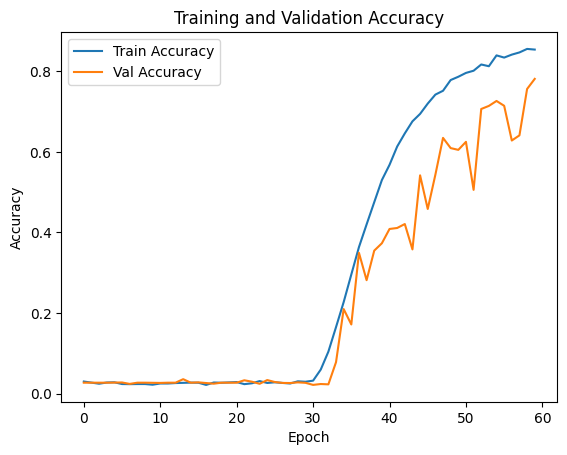

In [14]:
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# **Evaluating the model using Confusion Matrix and Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━

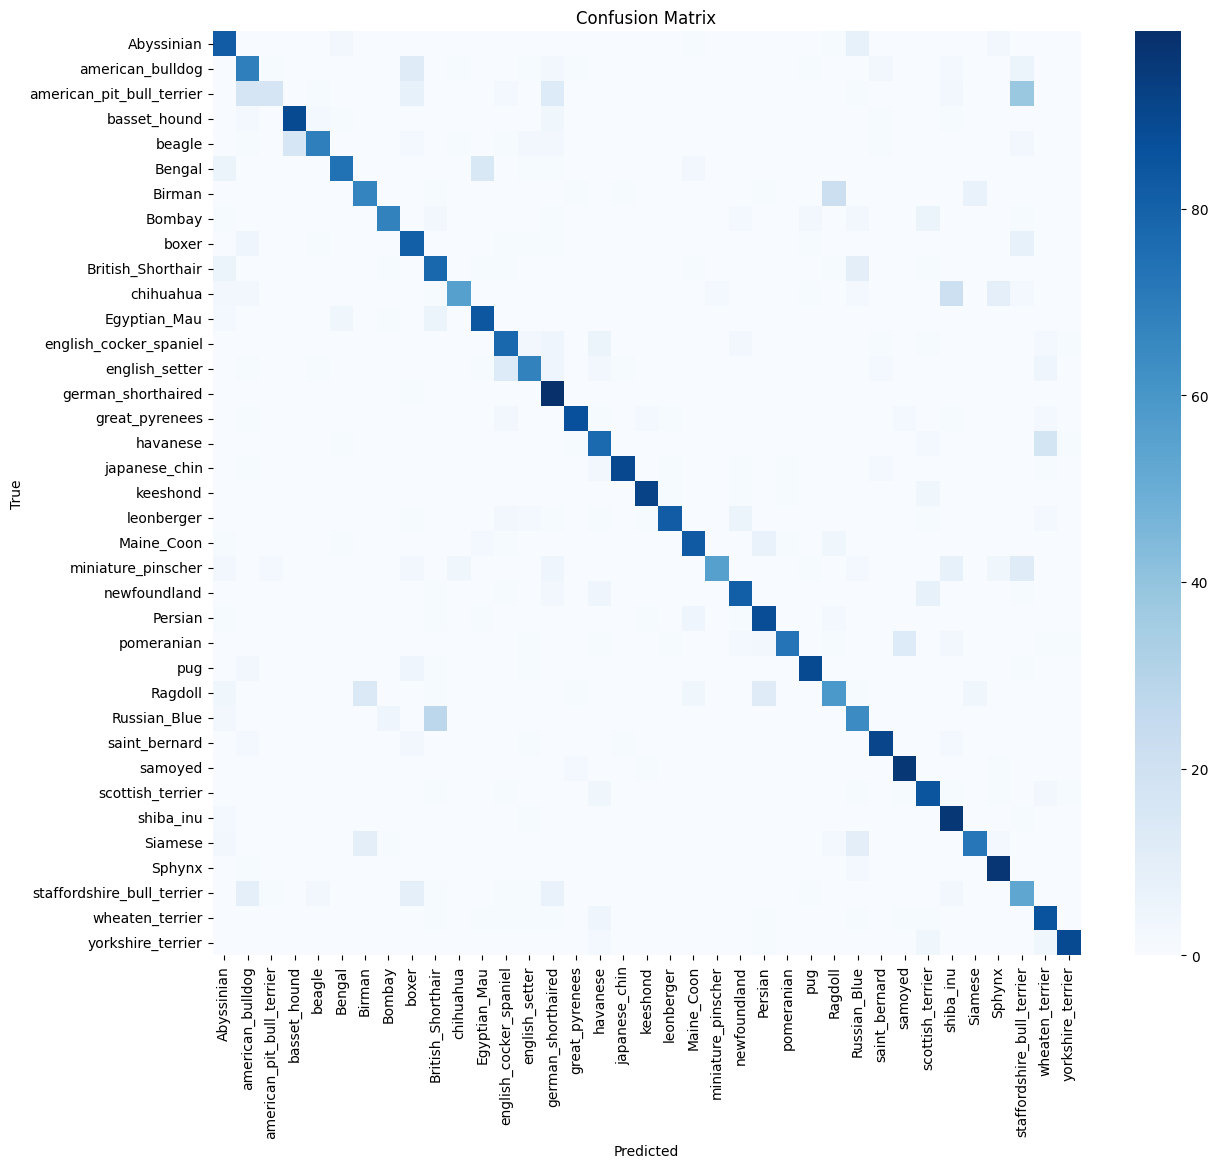

In [15]:
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues', annot=False, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Visualizing Model Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


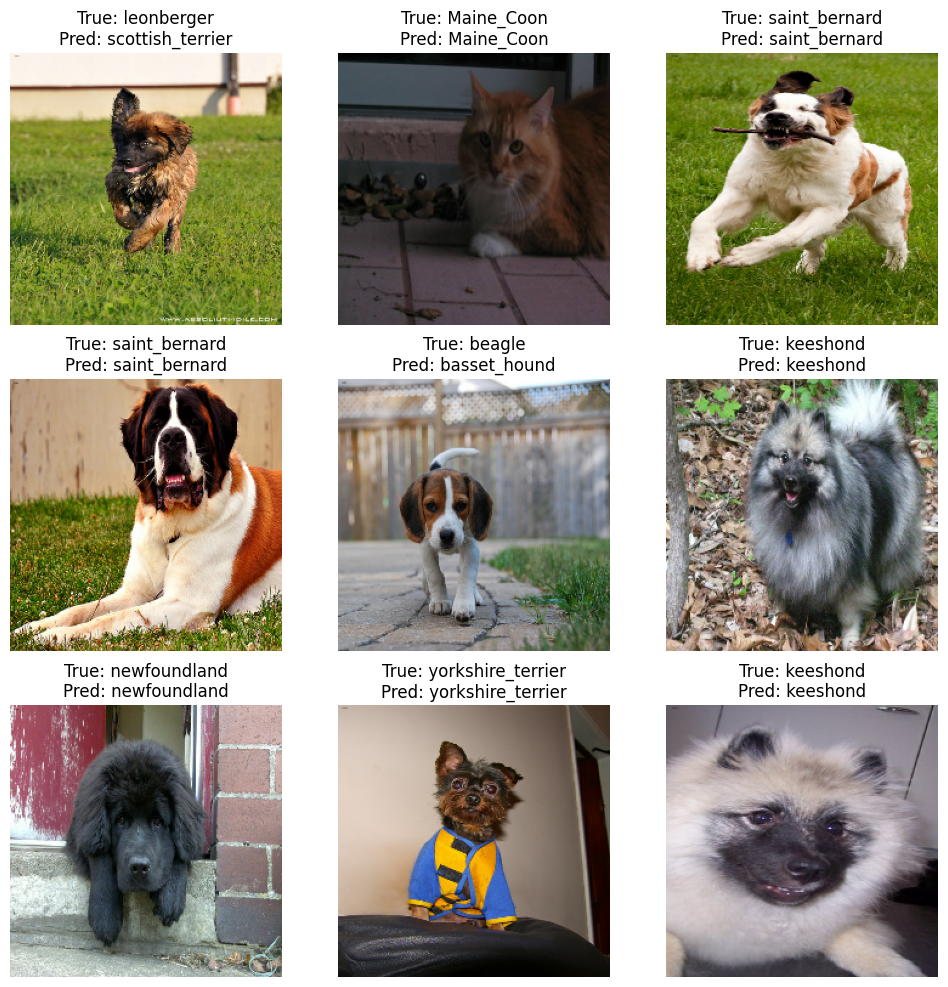

In [16]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_class = tf.argmax(preds, axis=1)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        true_lbl = CLASS_NAMES[labels[i].numpy()]
        pred_lbl = CLASS_NAMES[preds_class[i].numpy()]
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}")
        plt.axis("off")
    plt.show()